In [1]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn import cross_validation, grid_search, metrics, ensemble

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

/home/dada/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dada/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
import pandas as pd
ttt = pd.read_csv('../../merge.csv')
train_meta = pd.read_csv('../../stack/train_meta3.csv')
test_meta = pd.read_csv('../../stack/test_meta3.csv')
train_meta = train_meta.drop(columns=['Unnamed: 0'])
test_meta = test_meta.drop(columns=['Unnamed: 0'])
train_meta.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher,foldID,surprise,FM,keras,XGBRegressor,XGBClassifier
0,8.0,133745,6329,47.0,18959,41855,1992.0,560,3,7.0,7.0,8,7,7
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132,3,8.0,7.0,8,8,8
2,8.0,13559,886,29.0,4962,62104,0.0,11567,4,8.0,8.0,8,8,8
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678,5,8.0,7.0,8,7,8
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553,4,10.0,8.0,10,9,10


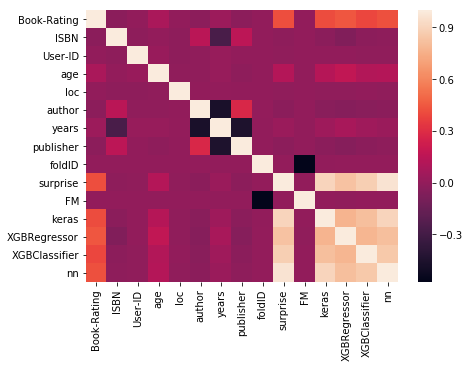

In [25]:
import seaborn as sns
plt.figure(figsize=[7,5])
sns.heatmap(train_meta.corr())
plt.show()

In [6]:
train_meta['nn'] = float('nan')
test_meta['nn'] = float('nan')
train_meta.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher,foldID,surprise,FM,keras,XGBRegressor,XGBClassifier,nn
0,8.0,133745,6329,47.0,18959,41855,1992.0,560,3,7.0,7.0,8,7,7,NaN
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132,3,8.0,7.0,8,8,8,NaN
2,8.0,13559,886,29.0,4962,62104,0.0,11567,4,8.0,8.0,8,8,8,NaN
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678,5,8.0,7.0,8,7,8,NaN
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553,4,10.0,8.0,10,9,10,NaN


In [8]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from model import *

In [7]:
n_users = ttt['User-ID'].nunique()
n_books = ttt['ISBN'].nunique()

In [23]:
# train and fill train meta
mean = 0
for f in range(5):
    train_fold = train_meta[train_meta.foldID != f+1]
    val_fold = train_meta[train_meta.foldID == f+1]
    
    user_train, book_train, rate_train = train_fold['User-ID'].values, train_fold['ISBN'].values, train_fold['Book-Rating'].values
    user_val, book_val, rate_val = val_fold['User-ID'].values, val_fold['ISBN'].values, val_fold['Book-Rating'].values
    
    train_loader = DataLoader(
            dataset=TensorDataset(
                torch.from_numpy(user_train),
                torch.from_numpy(book_train),
                torch.from_numpy(rate_train)),
            batch_size=1024,
            shuffle=True,
            num_workers=8)
    
    val_loader = DataLoader(
            dataset=TensorDataset(
                torch.from_numpy(user_val),
                torch.from_numpy(book_val),
                torch.from_numpy(rate_val)),
            batch_size=1024,
            num_workers=8)
    
    print ("fold", f+1, ', data length:', len(user_train))
    
    global_mean = rate_train.mean().item()
    model = Model(
            user_size = n_users + 1,
            book_size = n_books + 1,
            global_mean=global_mean).cuda()
    
    optimizer_u = torch.optim.SGD(model.user_bias.parameters(), lr=0.01)
    optimizer_b = torch.optim.SGD(model.book_bias.parameters(), lr=0.005)
    
    for epoch in range(45):
        print ('Epoch:', epoch, end='\r')
        for i ,(user, book, rate) in enumerate(train_loader):
            model.train()
            user, book, rate = user.cuda(), book.cuda(), rate.cuda()
            output, reg_loss = model(user, book)

            # MAE Loss
            loss = F.l1_loss(output, rate.float(), size_average=False)
            # MAPE Loss
            #loss = (F.l1_loss(output, rate, reduce=False) / rate).sum()

            optimizer_u.zero_grad()
            optimizer_b.zero_grad()
            loss.backward()
            optimizer_u.step()
            optimizer_b.step()
            
            
    model.eval()
    pred = []
    for i ,(user, book, rate) in enumerate(val_loader):
        user, book= user.cuda(), book.cuda()
        output = model(user, book, test=True)
        pred.append(output.detach().cpu().numpy())

    pred = np.hstack(pred)
    pred = np.round(pred)
    mae = MAE(pred, rate_val)
    mean += mae
    print ('validation score:', mae)
        
    train_meta['nn'][train_meta.foldID == f+1] = pred.astype(int)

print ('mean:', mean/5)

fold 1 , data length: 208161
validation score: 1.2156953171537825
fold 2 , data length: 208161
validation score: 1.2173862915777944
fold 3 , data length: 208162
validation score: 1.2192352036894696
fold 4 , data length: 208162
validation score: 1.217044581091468
fold 5 , data length: 208162
validation score: 1.2199846272098387
mean: 1.2178692041444708


In [40]:
# train on all and fill test meta
user_train, book_train, rate_train = train_meta['User-ID'].values, train_meta['ISBN'].values, train_meta['Book-Rating'].values
user_test, book_test = test_meta['User-ID'].values, test_meta['ISBN'].values

train_loader = DataLoader(
        dataset=TensorDataset(
            torch.from_numpy(user_train),
            torch.from_numpy(book_train),
            torch.from_numpy(rate_train)),
        batch_size=1024,
        shuffle=True,
        num_workers=8)

test_loader = DataLoader(
        dataset=TensorDataset(
            torch.from_numpy(user_test),
            torch.from_numpy(book_test)),
        batch_size=1024,
        num_workers=8)


global_mean = rate_train.mean().item()
model = Model(
        user_size = n_users + 1,
        book_size = n_books + 1,
        global_mean=global_mean).cuda()

optimizer_u = torch.optim.SGD(model.user_bias.parameters(), lr=0.01)
optimizer_b = torch.optim.SGD(model.book_bias.parameters(), lr=0.005)

for epoch in range(45):
    print ('Epoch:', epoch, end='\r')
    for i ,(user, book, rate) in enumerate(train_loader):
        model.train()
        user, book, rate = user.cuda(), book.cuda(), rate.cuda()
        output, reg_loss = model(user, book)

        # MAE Loss
        loss = F.l1_loss(output, rate.float(), size_average=False)
        # MAPE Loss
        #loss = (F.l1_loss(output, rate, reduce=False) / rate).sum()

        optimizer_u.zero_grad()
        optimizer_b.zero_grad()
        loss.backward()
        optimizer_u.step()
        optimizer_b.step()


model.eval()
pred = []
for i ,(user, book) in enumerate(test_loader):
    user, book= user.cuda(), book.cuda()
    output = model(user, book, test=True)
    pred.append(output.detach().cpu().numpy())

pred = np.hstack(pred)
pred = np.round(pred)
test_meta['nn'] = pred.astype(int)

In [42]:
train_meta.to_csv('nn_train_meta3.csv')
test_meta.to_csv('nn_test_meta3.csv')
train_meta.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher,foldID,surprise,FM,keras,XGBRegressor,XGBClassifier,nn
0,8.0,133745,6329,47.0,18959,41855,1992.0,560,3,7.0,7.0,8,7,7,7.0
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132,3,8.0,7.0,8,8,8,8.0
2,8.0,13559,886,29.0,4962,62104,0.0,11567,4,8.0,8.0,8,8,8,8.0
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678,5,8.0,7.0,8,7,8,8.0
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553,4,10.0,8.0,10,9,10,10.0


In [24]:
# baselines
stack_feature_list = ['XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'FM', 'nn']
pred = []
for i in stack_feature_list:
    print (i)
    p = train_meta[i].values
    print (MAE(p, train_meta['Book-Rating'].values))
    pred.append(p)
    
pred = np.round(np.mean(pred, 0))
print ('mean')
print (MAE(pred, train_meta['Book-Rating'].values))

XGBRegressor
1.2264433017424923
XGBClassifier
1.266796565745075
surprise
1.2186493570379935
keras
1.2332072774229252
FM
1.4966064826557828
nn
1.2178691939339437
mean
1.231470165486814


In [26]:
# test stack model
from sklearn.svm import LinearSVR
stack_feature_list = ['XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'FM', 'nn']
mean = 0
for f in range(5):
    train_fold = train_meta[train_meta.foldID != f+1]
    val_fold = train_meta[train_meta.foldID == f+1]

    x_train, y_train = train_fold[stack_feature_list], train_fold['Book-Rating']
    x_val, y_val = val_fold[stack_feature_list], val_fold['Book-Rating']
    
    print ("fold", f+1, ', data length:', len(x_train))
    model = LinearSVR()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    pred = np.round(pred)
    mae = MAE(pred, y_val)
    mean += mae
    print ("\t", 'validation score:', mae)

print ('mean:', mean/5)

fold 1 , data length: 208161
	 validation score: 1.2160604139044215
fold 2 , data length: 208161
	 validation score: 1.2087776945100979
fold 3 , data length: 208162
	 validation score: 1.2133743274404305
fold 4 , data length: 208162
	 validation score: 1.2098001537279015
fold 5 , data length: 208162
	 validation score: 1.2126825518831668
mean: 1.2121390282932034


In [28]:
from sklearn.metrics import make_scorer
def my_mae(ground, preds):
    return MAE(ground, np.round(preds))

In [30]:
# create combinations of features
from itertools import combinations
all_combin = []
for k in range(1, len(stack_feature_list)+1):
    for j in combinations(stack_feature_list, k):
        all_combin.append(j)

for i in all_combin:
    print (i)

('XGBRegressor',)
('XGBClassifier',)
('surprise',)
('keras',)
('FM',)
('nn',)
('XGBRegressor', 'XGBClassifier')
('XGBRegressor', 'surprise')
('XGBRegressor', 'keras')
('XGBRegressor', 'FM')
('XGBRegressor', 'nn')
('XGBClassifier', 'surprise')
('XGBClassifier', 'keras')
('XGBClassifier', 'FM')
('XGBClassifier', 'nn')
('surprise', 'keras')
('surprise', 'FM')
('surprise', 'nn')
('keras', 'FM')
('keras', 'nn')
('FM', 'nn')
('XGBRegressor', 'XGBClassifier', 'surprise')
('XGBRegressor', 'XGBClassifier', 'keras')
('XGBRegressor', 'XGBClassifier', 'FM')
('XGBRegressor', 'XGBClassifier', 'nn')
('XGBRegressor', 'surprise', 'keras')
('XGBRegressor', 'surprise', 'FM')
('XGBRegressor', 'surprise', 'nn')
('XGBRegressor', 'keras', 'FM')
('XGBRegressor', 'keras', 'nn')
('XGBRegressor', 'FM', 'nn')
('XGBClassifier', 'surprise', 'keras')
('XGBClassifier', 'surprise', 'FM')
('XGBClassifier', 'surprise', 'nn')
('XGBClassifier', 'keras', 'FM')
('XGBClassifier', 'keras', 'nn')
('XGBClassifier', 'FM', 'nn')


In [32]:
# feature selection
best_score = 99
best_com = ""

for com in all_combin:
    
    stack_feature_list = [i for i in com]
    print (stack_feature_list)

    S = LinearSVR()
    parameters = {'C':[1]}
    
    grid = grid_search.GridSearchCV(S,
                            parameters,
                            cv = 5,
                            n_jobs = 5,
                            scoring = make_scorer(my_mae, greater_is_better=False),
                            verbose=True)

    grid.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])

    if -grid.best_score_ < best_score:
        best_score = -grid.best_score_
        best_com = com
    print (-grid.best_score_ , best_score)
    
print (best_score, best_com)

['XGBRegressor']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


1.2264433017424923 1.2264433017424923
['XGBClassifier']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.0s finished


1.266796565745075 1.2264433017424923
['surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


1.2186493570379935 1.2186493570379935
['keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.1s finished


1.2332072774229252 1.2186493570379935
['FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.7s finished


1.434985126939839 1.2186493570379935
['nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s finished


1.2178691939339437 1.2178691939339437
['XGBRegressor', 'XGBClassifier']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.2s finished


1.2264433017424923 1.2178691939339437
['XGBRegressor', 'surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   13.4s remaining:   20.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.2s finished


1.2186493570379935 1.2178691939339437
['XGBRegressor', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.4s finished


1.223672377614315 1.2178691939339437
['XGBRegressor', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.1s finished


1.2264433017424923 1.2178691939339437
['XGBRegressor', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   16.1s remaining:   24.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.3s finished


1.2178691939339437 1.2178691939339437
['XGBClassifier', 'surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.2s finished


1.2186493570379935 1.2178691939339437
['XGBClassifier', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.5s remaining:   29.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.4s finished


1.2332072774229252 1.2178691939339437
['XGBClassifier', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   11.1s finished


1.266796565745075 1.2178691939339437
['XGBClassifier', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.4s finished


1.2178691939339437 1.2178691939339437
['surprise', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.6s remaining:   15.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   11.2s finished


1.2186493570379935 1.2178691939339437
['surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.7s finished


1.2186493570379935 1.2178691939339437
['surprise', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   12.8s finished


1.2178691939339437 1.2178691939339437
['keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.8s finished


1.2332072774229252 1.2178691939339437
['keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   12.7s finished


1.2178691939339437 1.2178691939339437
['FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.6s finished


1.2178691939339437 1.2178691939339437
['XGBRegressor', 'XGBClassifier', 'surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.1s remaining:   36.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.0s finished


1.2186493570379935 1.2178691939339437
['XGBRegressor', 'XGBClassifier', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.5s finished


1.2235301803983059 1.2178691939339437
['XGBRegressor', 'XGBClassifier', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.9s remaining:   29.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.4s finished


1.2264433017424923 1.2178691939339437
['XGBRegressor', 'XGBClassifier', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.4s remaining:   35.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.5s finished


1.217861507597943 1.217861507597943
['XGBRegressor', 'surprise', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.8s remaining:   35.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.7s finished


1.2186493570379935 1.217861507597943
['XGBRegressor', 'surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   18.7s remaining:   28.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   19.9s finished


1.2186493570379935 1.217861507597943
['XGBRegressor', 'surprise', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.3s remaining:   35.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.4s finished


1.2178691939339437 1.217861507597943
['XGBRegressor', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.9s remaining:   29.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.4s finished


1.223672377614315 1.217861507597943
['XGBRegressor', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.0s remaining:   36.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.4s finished


1.2178691939339437 1.217861507597943
['XGBRegressor', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.1s finished


1.2178691939339437 1.217861507597943
['XGBClassifier', 'surprise', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.8s remaining:   29.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.8s finished


1.2186493570379935 1.217861507597943
['XGBClassifier', 'surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   18.9s remaining:   28.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   23.8s finished


1.2186493570379935 1.217861507597943
['XGBClassifier', 'surprise', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.6s finished


1.2178691939339437 1.217861507597943
['XGBClassifier', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.9s remaining:   35.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.7s finished


1.2332072774229252 1.217861507597943
['XGBClassifier', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   22.3s remaining:   33.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   23.6s finished


1.2178691939339437 1.217861507597943
['XGBClassifier', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.9s finished


1.2178691939339437 1.217861507597943
['surprise', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.3s finished


1.2186493570379935 1.217861507597943
['surprise', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.7s remaining:   29.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.4s finished


1.2178691939339437 1.217861507597943
['surprise', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   16.8s remaining:   25.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.0s finished


1.2178691939339437 1.217861507597943
['keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.0s remaining:   25.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.8s finished


1.2178691939339437 1.217861507597943
['XGBRegressor', 'XGBClassifier', 'surprise', 'keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.6s finished


1.2184264532939793 1.217861507597943
['XGBRegressor', 'XGBClassifier', 'surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.6s remaining:   41.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   28.5s finished


1.2186493570379935 1.217861507597943
['XGBRegressor', 'XGBClassifier', 'surprise', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.3s remaining:   44.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.3s finished


1.2173887979339129 1.2173887979339129
['XGBRegressor', 'XGBClassifier', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.6s remaining:   41.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.9s finished


1.2157977263818112 1.2157977263818112
['XGBRegressor', 'XGBClassifier', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.1s finished


1.216750832045872 1.2157977263818112
['XGBRegressor', 'XGBClassifier', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.1s remaining:   37.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.4s finished


1.2175079361419205 1.2157977263818112
['XGBRegressor', 'surprise', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   26.2s remaining:   39.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.4s finished


1.2186493570379935 1.2157977263818112
['XGBRegressor', 'surprise', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.3s finished


1.2172427575499036 1.2157977263818112
['XGBRegressor', 'surprise', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.4s remaining:   38.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.5s finished


1.2177731147339375 1.2157977263818112
['XGBRegressor', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.8s remaining:   38.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.4s finished


1.217750055725936 1.2157977263818112
['XGBClassifier', 'surprise', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.0s remaining:   42.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.6s finished


1.2186493570379935 1.2157977263818112
['XGBClassifier', 'surprise', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.6s remaining:   42.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.0s finished


1.2178691939339437 1.2157977263818112
['XGBClassifier', 'surprise', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.3s remaining:   38.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.8s finished


1.2178691939339437 1.2157977263818112
['XGBClassifier', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.9s remaining:   41.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.4s finished


1.2178691939339437 1.2157977263818112
['surprise', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.7s remaining:   37.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.5s finished


1.2178691939339437 1.2157977263818112
['XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.5s remaining:   45.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.3s finished


1.2175271519819217 1.2157977263818112
['XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.7s remaining:   46.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   32.6s finished


1.2127731531656174 1.2127731531656174
['XGBRegressor', 'XGBClassifier', 'surprise', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.3s remaining:   45.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.6s finished


1.2160513754698272 1.2127731531656174
['XGBRegressor', 'XGBClassifier', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.5s finished


1.2135533162696674 1.2127731531656174
['XGBRegressor', 'surprise', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.8s remaining:   46.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.5s finished


1.216451064941853 1.2127731531656174
['XGBClassifier', 'surprise', 'keras', 'FM', 'nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.1s remaining:   45.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.6s finished


1.2178691939339437 1.2127731531656174
1.2127731531656174 ('XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'nn')


In [37]:
# hyperparameters grid search
stack_feature_list = [i for i in best_com]
S = LinearSVR()
parameters = {'C':[0.01, 0.1, 1, 10]}
grid = grid_search.GridSearchCV(S,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        scoring = make_scorer(my_mae, greater_is_better=False),
                        verbose=True)

grid.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])

print(grid.best_score_)
print(grid.best_params_)
print(grid.grid_scores_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  2.1min finished


-1.2109169030214988
{'C': 1}
[mean: -1.21787, std: 0.00527, params: {'C': 0.01}, mean: -1.21787, std: 0.00527, params: {'C': 0.1}, mean: -1.21092, std: 0.00459, params: {'C': 1}, mean: -1.81736, std: 0.48884, params: {'C': 10}]


In [47]:
# fit on all train data
print (stack_feature_list)
S = LinearSVR(**grid.best_params_)
S.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])

from sklearn.externals import joblib
joblib.dump(model, 'stack.pkl')

['XGBRegressor', 'XGBClassifier', 'surprise', 'keras', 'FM', 'nn']


['stack.pkl']

In [48]:
# output
final_pred = S.predict(test_meta[stack_feature_list])
with open('final.csv', 'w') as f:
    for i in final_pred:
        print (int(round(i)), file=f)

In [51]:
pred_collections = []
pred_collections.append(final_pred)

for _ in range(20):
    S = LinearSVR(**grid.best_params_)
    S.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])
    pred = S.predict(test_meta[stack_feature_list])
    pred_collections.append(pred)

pred = np.mean(pred_collections, 0)
pred = np.round(pred).astype(int)
with open('finals.csv', 'w') as f:
    for i in pred:
        print (i, file=f)